> # Neural Network Basic - Week3 과제


## Import Library

In [4]:
#pip install datasets
#!pip install mnist

In [18]:
  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=True)
    return x_test, t_test

In [20]:
#from datasets.MNIST import load_mnist

In [21]:
from keras.datasets import mnist


In [22]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [46]:
import numpy as np
from matplotlib import pyplot as plt
#from datasets.MNIST import load_mnist


## Load Dataset
- MNIST 

In [7]:
#(X_train, Y_train), (X_test, Y_test) = \
    #load_mnist(normalize=True, one_hot_label=False)

In [25]:
X_test = X_test.reshape(-1, 28**2)
X_test.shape


(10000, 784)

In [26]:
X_train = X_train.reshape(-1, 28**2)
X_train.shape

(60000, 784)

In [28]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y_train shape: {y_train.shape}')
print(f'Y_train shape: {y_test.shape}')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
Y_train shape: (60000,)
Y_train shape: (10000,)


## Activation Function 
- sigmoid & relu : hidden layer activation function 
- softmax : output layer activation function 

In [31]:
class sigmoid:
    # sigmoid 함수를 작성하세요 
    def forward(x):
        return 1/ (1 + np.exp(-x))
    
    # sigmoid 함수의 미분을 작성하세요
    def backward(x):
        return x * (1 - x)

In [32]:
class relu:
    # relu 함수를 작성하세요
    def forward(x):
        return np.maximum(0,x) # 0 아래는 0으로!
    
    # relu 함수의 미분을 작성하세요
    def backward(x):
        return np.where(x>0,1,0) # x가 0보다 크면 1 아니면 0으로!

In [33]:
class softmax:
    def forward(z):
        y = []
        for zi in z:
            c = np.max(zi)
            exp_zi = np.exp(zi-c)
            sum_exp_zi = np.sum(exp_zi)
            yi = exp_zi / sum_exp_zi
            y.append(yi)

        return np.array(y)
    
    def backward(p, y) :
        dp = p.copy()
        for dpi, yi in zip(dp, y):
            for k in range(dp.shape[1]):
                if k == yi :
                    dpi[k] -= 1
        return dp

## Loss Function

In [34]:
def cross_entropy(p, y):
    loss = []
    for pi, yi in zip(p, y):
        for k in range(p.shape[1]):
            if k == yi:
                loss.append((-1) * (np.log(pi[k] + 1e-8))) 
    return loss

## Layer

In [35]:
class Layer:
    def __init__(self, input_size, output_size, std=1e-4) :
        self.input_size = input_size
        self.output_size = output_size
        self.bias = np.random.randn(output_size)
        self.weight = np.random.randn(input_size, output_size)*std

## Neural Network
- 각 메소드와 변수들의 역할을 주석으로 달아주세요! 

In [36]:
class CustomNet:
    # CustomNet을 선언할 때 생성되는 값들입니다.
    def __init__(self, lr=0.0001, epoch=500, batch_size=200):
        self.lr = lr # 지정된 learning rate 를 사용한다. 
        self.epoch = epoch  # 모델이 학습을 반복하는 횟수를 입력한다. 
        self.batch_size = batch_size #batch는 데이터를 잘게 잘라서 사용하는 것이므로 얼마나 작게 나누어야 하는지 알게해줌. 
        self.loss_function = cross_entropy #loss function중에 binary에 주요 사용되는 cross entropy를 선택 
        self.layers = [] # 리스트 layser , 점점 append 되어짐
        self.activations = [softmax] # 활성화 함수로는 softmax를 사용한다. 
        self.nodes = [] # 레이어에 대한 노드의 수 
    
    # Layer를 추가할 때 호출합니다
    def addLayer(self, Layer): 
        self.layers.append(Layer) 
        if not self.nodes: 
            self.nodes.append(np.zeros(Layer.input_size))
        self.nodes.append(np.zeros(Layer.output_size))
        
    # Activation Function을 추가할 때 호출합니다
    def addActivation(self, Activation):
        tmp = self.activations.pop() #가장 뒷부분에 있는 활성화 함수를 의미 , pop()은 리스트의 마지막 원소를 뽑아낸다. 
        self.activations.append(Activation) 
        self.activations.append(tmp) # 마지막에 추가되는 tmp
        
    # 순전파 함수
    def _forward(self, X):
        self.nodes[0] = X.copy() # node를 초기화시키기 위함. 
        output = X.copy() # output 에 x를 담는다. 
        for i in range(len(self.layers)): # len(layer) 는 layer 의 개수를 뜻함으로 그 수만큼 반복문을 말한다. 
            Layer = self.layers[i] # 개별 레이어를 지정한다. 
            Activation = self.activations[i] #레이어에 대한 활성화 함수를 따로 지정한다. 
            output = np.dot(self.nodes[i], Layer.weight) # dot은 내적을 의미하므로 , 노드의 값과 가중치를 곱한다. 
            output = output+ Layer.bias # 상수 추가 
            output = Activation.forward(output) #활성화를 적용한다. 
            self.nodes[i+1] = output #다음 결과로 다시 출력 -> 최종 output 
        return output   
    
    # 역전파 함수
    def _backward(self, X, output, y) :
        for i in reversed(range(len(self.layers))): # reversed란 반대로 출력하는 것을 의미하므로 layer 길이 반대부터!
            a = self.nodes[i+1] 
            Layer = self.layers[i] 
            Activation = self.activations[i] 
            
            if i+1 == len(self.layers): # layer마다 따로 실제값과 y값의 에러를 업데이터 시켜야한다. 
                error = Activation.backward(output, y)
            else:
                error *= Activation.backward(a)
            Layer.weight -= np.dot(error.T, self.nodes[i]).T*self.lr/X.shape[0] 
            Layer.bias -= error.sum(axis=0)*self.lr/X.shape[0]
            error = np.dot(error, Layer.weight.T) 
            
    # Accrucy를 반환합니다
    def _accuracy(self, output, y):
        pre_p = np.argmax(output, axis=1) # argmax는 가장 높은 값
        return np.sum(pre_p==y)/y.shape[0] # true일때 예측값도 true인 값들을 출력한다. 
    
    # 데이터셋에 모델을 fit할때 호출합니다
    def fit(self, X, y, val_X, val_y):
        history = {'val_acc': [],'val_loss': []}
        N = X.shape[0]
        for i in range(self.epoch):# epoch 수만큼 range 만들어야 함. 
            for j in range(N//self.batch_size): 
                batch_mask = np.random.choice(N, self.batch_size)
                X_batch = X[batch_mask] 
                y_batch = y[batch_mask] 
                output = self._forward(X_batch) 
                self._backward(X_batch, output, y_batch)
            
            #accuracy와 loss를 기록해둡시다
            output = self._forward(val_X) # validation에 대한 forward값 
            history["val_acc"].append(self._accuracy(output, val_y)) 
            history["val_loss"].append(sum(self.loss_function(output, val_y))) 
            
            #중간중간 기록을 찍어볼 때 사용. 적절히 조절해 쓰세요
            if i % 10 == 0:
                print(i, "test accuracy :", history["val_acc"][-1])
                print(i, "test loss     :", history["val_loss"][-1])
        return history

## Customizing
- Network parameter, Layer architecture, Activation function .. 등등 다양한 하이퍼파라미터를 커스터마이징하여 높은 성능에 도달해 봅시다! 

In [37]:
# 하이퍼파라미터를 적절히 조절해 뉴럴넷을 선언하세요
nn = CustomNet(lr=0.005, epoch=200, batch_size=400)

# 원하는 만큼 층과 활성화 함수를 쌓아 주세요. 기본적으로 2Layer를 예시로 적어드립니다
nn.addLayer(Layer(784,100))
nn.addActivation(sigmoid)
nn.addLayer(Layer(100,10))

In [38]:
# 선언한 뉴럴넷의 구조입니다
for layer in nn.layers:
    print(layer.weight.shape, layer.bias.shape)

(784, 100) (100,)
(100, 10) (10,)


In [39]:
history = nn.fit(X_train, y_train, X_test, y_test)

0 test accuracy : 0.4857
0 test loss     : 19708.06348489572
10 test accuracy : 0.9198
10 test loss     : 4328.999563167179
20 test accuracy : 0.934
20 test loss     : 2915.8724622681193
30 test accuracy : 0.9408
30 test loss     : 2451.1725787278256
40 test accuracy : 0.9422
40 test loss     : 2222.493832155361
50 test accuracy : 0.945
50 test loss     : 2077.7237881660985
60 test accuracy : 0.9448
60 test loss     : 1987.591253808151
70 test accuracy : 0.9461
70 test loss     : 1902.780658685623
80 test accuracy : 0.9477
80 test loss     : 1823.701548140758
90 test accuracy : 0.9468
90 test loss     : 1803.0483976758246
100 test accuracy : 0.9484
100 test loss     : 1757.5582675093726
110 test accuracy : 0.9474
110 test loss     : 1737.6955332096718
120 test accuracy : 0.9481
120 test loss     : 1705.3713503736408
130 test accuracy : 0.9484
130 test loss     : 1698.0807826435828
140 test accuracy : 0.949
140 test loss     : 1679.4905719825024
150 test accuracy : 0.9499
150 test loss 

## Accuracy, Loss Visualization
- 자유롭게 Accuracy나 Loss를 시각화하여 확인하고 결과를 확인해 보세요! 

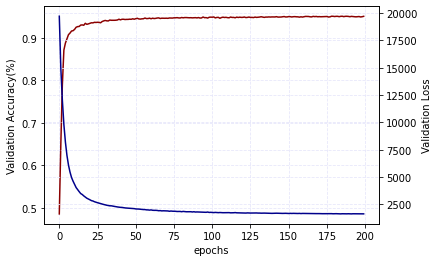

Best Validation Accuracy :  0.9507


In [45]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(200), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(200), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Loss')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')


plt.show()


print("Best Validation Accuracy : ",max(history['val_acc']))